In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_train = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/train.csv')
data_test = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/test.csv')
pseudo_labels_test = pd.read_csv('D:/Python/Anaconda/Kaggle/Working/Tabular Playground Apr 2021/data/pseudo_submission.csv')

data_test_labeled = data_test.copy()
data_test_labeled['Survived'] = pseudo_labels_test['Survived']

all_data = pd.concat([data_train, data_test_labeled]).reset_index(drop=True)

In [3]:
def label_encoder(column):
    lc = LabelEncoder()
    return lc.fit_transform(column)

In [4]:
def titanic_preprocessing(df):
    age = df[['Age', 'Pclass']].dropna().groupby('Pclass').mean().to_dict()
    df['Age'] = df['Age'].fillna(df['Pclass'].map(age['Age']))

    df['Fare'].fillna(df['Fare'].median(), inplace=True)

    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # Ticket
    df['Ticket'] = df['Ticket'].fillna('X').map(lambda x: str(x).split()[0] if len(str(x).split()) > 1 else 'X')

    # Cabin
    df['Cabin'] = df['Cabin'].fillna('X').map(lambda x: x[0].strip()) 

    df.drop(['PassengerId', 'Name'], axis=1, inplace=True)

    return df

In [5]:
def titanic_feature_engineering(df):
    # Create dummy variables
    dummy = pd.get_dummies(df[['Embarked', 'Cabin']], dtype=np.int32)
    df = pd.concat([df, dummy], axis=1)
    df.drop(['Embarked', 'Cabin'], axis=1, inplace=True)

    # Label Encoder
    ticket_labeled = df[['Ticket']].apply(label_encoder)
    ticket_labeled.columns = ['Ticket labeled']
    df = pd.concat([df, ticket_labeled], axis=1)
    df.drop(['Ticket'], axis=1, inplace=True)

    df['Sex_dummy'] = df['Sex'].map({'male': 0, 'female': 1})
    df.drop(['Sex'], axis=1, inplace=True)

    return df

In [6]:
def dataset_preparation(df):
    df = titanic_preprocessing(df)
    df = titanic_feature_engineering(df)
    return df

In [7]:
# data_train_copy = data_train.copy()
data_test_copy = data_test.copy()
all_data_copy = all_data.copy()

# data_train_prep = dataset_preparation(data_train_copy)
data_test_prep = dataset_preparation(data_test_copy)
all_data_prep = dataset_preparation(all_data_copy)

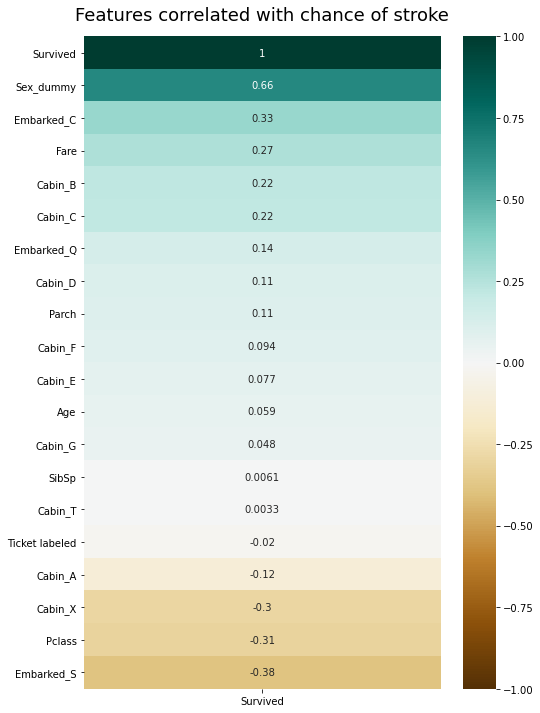

In [8]:
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(all_data_prep.corr()[['Survived']].sort_values(by='Survived', ascending=False),
                     vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Features correlated with chance of stroke', fontdict={'fontsize': 18}, pad=16);

In [9]:
# Split data into train and validation sets
X = all_data_prep.drop(['Survived'], axis=1)
y = all_data_prep['Survived']

# Scalling
# scaler = StandardScaler()
# X[X.columns] = scaler.fit_transform(X[X.columns])
# data_test_scaled = scaler.fit_transform(data_test_prep)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [10]:
def model_evaluation(model):
    # Train our model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # F1 score
    scores_f1 = cross_val_score(model, X, y, scoring = 'f1' ,cv=5)
    print('F1 scores: {}'.format(scores_f1))
    print('F1 mean score: {}'.format(scores_f1.mean()))

    # Accuracy score
    scores_acc = cross_val_score(model, X, y, cv=5)
    print('Acc scores: {}'.format(scores_acc))
    print('Acc mean score: {}'.format(scores_acc.mean()))
    
    # Confusion matrix
    print('Confusion Matrix: ')
    matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts =['{0:0.0f}'.format(value) for value in matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(matrix, annot=labels, fmt='', cmap='rocket_r')

<h1> Light Gradient Boost Classifier </h1>

In [11]:
# # get a list of models to evaluate
# def get_models():
# 	models = dict()
# 	trees = range(50, 150, 5)
# 	for n in trees:
# 		models[str(n)] = LGBMClassifier(n_estimators=n)
# 	return models
 
# # evaluate a give model using cross-validation
# def evaluate_model(model):
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# 	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# 	return scores

In [12]:
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model)
# 	results.append(scores)
# 	names.append(name)
# 	print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

In [13]:
# fig = go.Figure()

# for num, result in enumerate(results):
#     fig.add_trace(go.Box(
#     y = result,
#     name=names[num]
#     ))

# fig.show()

In [14]:
# LightGBM
LGBM_model = LGBMClassifier(
    metric = 'binary_logloss',
    n_estimators = 10000,
    objective = 'binary',
    random_state = 42,
    learning_rate = 0.01,
    min_child_samples = 150,
    reg_alpha = 3e-5,
    reg_lambda = 9e-2,
    num_leaves = 20,
    max_depth = 16,
    colsample_bytree = 0.8,
    subsample = 0.8,
    subsample_freq = 2,
    max_bin = 240
)

# model_evaluation(LGBM_model)

In [15]:
# parameters = {
#     'num_leaves': range(25, 50, 1)
# }

# search = GridSearchCV(LGBM_model, parameters, verbose=3, scoring='f1')
# search.fit(X_train, y_train)

In [16]:
# print('Best Score for LGB: {} \nWith params: {}'.format(search.best_score_, search.best_params_))

In [17]:
LGBM_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50)
# y_pred = LGBM_model.predict(data_test_prep)
y_pred_proba_light = LGBM_model.predict_proba(data_test_prep)

# my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred})
# my_submission.to_csv('submission_v4.csv', index=False)

gloss: 0.292255
[3335]	valid_0's binary_logloss: 0.292255
[3336]	valid_0's binary_logloss: 0.292254
[3337]	valid_0's binary_logloss: 0.292255
[3338]	valid_0's binary_logloss: 0.292256
[3339]	valid_0's binary_logloss: 0.292258
[3340]	valid_0's binary_logloss: 0.292259
[3341]	valid_0's binary_logloss: 0.292259
[3342]	valid_0's binary_logloss: 0.292258
[3343]	valid_0's binary_logloss: 0.292258
[3344]	valid_0's binary_logloss: 0.292248
[3345]	valid_0's binary_logloss: 0.29225
[3346]	valid_0's binary_logloss: 0.292251
[3347]	valid_0's binary_logloss: 0.292251
[3348]	valid_0's binary_logloss: 0.29225
[3349]	valid_0's binary_logloss: 0.292251
[3350]	valid_0's binary_logloss: 0.292245
[3351]	valid_0's binary_logloss: 0.292246
[3352]	valid_0's binary_logloss: 0.292245
[3353]	valid_0's binary_logloss: 0.292245
[3354]	valid_0's binary_logloss: 0.292245
[3355]	valid_0's binary_logloss: 0.292243
[3356]	valid_0's binary_logloss: 0.292241
[3357]	valid_0's binary_logloss: 0.292241
[3358]	valid_0's bin

<h1> CatBoost </h1>

In [18]:
cat_model = CatBoostClassifier(
    # silent=True,
    bootstrap_type = 'Poisson',
    loss_function = 'Logloss',
    eval_metric = 'Logloss',
    random_seed = 42,
    task_type = 'GPU',
    max_depth = 8,
    learning_rate = 0.01,
    n_estimators = 2500,
    max_bin = 280,
    min_data_in_leaf = 64,
    l2_leaf_reg = 0.01,
    subsample = 0.8
)

# model_evaluation(cat_model)

In [19]:
cat_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50)
# y_pred_cat = cat_model.predict(data_test_prep)
y_pred_proba_cat = cat_model.predict_proba(data_test_prep)

# my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred})
# my_submission.to_csv('submission_v5.csv', index=False)

.7s	remaining: 4.53s
2283:	learn: 0.2774579	test: 0.2932795	best: 0.2932795 (2283)	total: 47.7s	remaining: 4.51s
2284:	learn: 0.2774492	test: 0.2932783	best: 0.2932783 (2284)	total: 47.7s	remaining: 4.49s
2285:	learn: 0.2774432	test: 0.2932780	best: 0.2932780 (2285)	total: 47.8s	remaining: 4.47s
2286:	learn: 0.2774334	test: 0.2932808	best: 0.2932780 (2285)	total: 47.8s	remaining: 4.45s
2287:	learn: 0.2774245	test: 0.2932784	best: 0.2932780 (2285)	total: 47.8s	remaining: 4.43s
2288:	learn: 0.2774104	test: 0.2932746	best: 0.2932746 (2288)	total: 47.8s	remaining: 4.41s
2289:	learn: 0.2774012	test: 0.2932714	best: 0.2932714 (2289)	total: 47.8s	remaining: 4.39s
2290:	learn: 0.2773925	test: 0.2932686	best: 0.2932686 (2290)	total: 47.9s	remaining: 4.37s
2291:	learn: 0.2773871	test: 0.2932661	best: 0.2932661 (2291)	total: 47.9s	remaining: 4.34s
2292:	learn: 0.2773782	test: 0.2932673	best: 0.2932661 (2291)	total: 47.9s	remaining: 4.32s
2293:	learn: 0.2773664	test: 0.2932702	best: 0.2932661 (229

<h1> Decision Tree Model </h1>

In [20]:
tree_model = DecisionTreeClassifier(
    random_state = 42,
    max_depth = 4,
    min_samples_leaf = 2
)

In [21]:
tree_model.fit(X_train, y_train)
# y_pred_tree = tree_model.predict(data_test_prep)
y_pred_proba_tree = tree_model.predict_proba(data_test_prep)

# my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred})
# my_submission.to_csv('submission_v5.csv', index=False)

In [22]:
# estimators = [
#     ('LGBM', LGBM_model),
#     ('Tree', tree_model)
# ]

# super_model = StackingClassifier(estimators=estimators, final_estimator=cat_model)

In [23]:
# model_evaluation(super_model)

In [24]:
# super_model.fit(X, y)
# y_pred = super_model.predict(data_test_prep)
# # y_pred_proba = super_model.predict_proba(data_test_prep)

# my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': y_pred})
# my_submission.to_csv('submission_v7.csv', index=False)

In [25]:
submissions = pd.DataFrame()
submissions['submit_lgb'] = np.where(y_pred_proba_light[:, 1] > 0.5, 1, 0)
submissions['submit_cat'] = np.where(y_pred_proba_cat[:, 1] > 0.5, 1, 0)
submissions['submit_tree'] = np.where(y_pred_proba_tree[:, 1] > 0.5, 1, 0)

In [26]:
submissions.head(100)

,submit_lgb,submit_cat,submit_tree
0,0,0,0
1,1,1,1
2,1,1,1
3,0,0,0
4,1,1,1
...,...,...,...
95,0,0,0
96,0,0,0
97,1,1,1
98,0,0,0


In [27]:
submissions[[col for col in submissions.columns if col.startswith('submit_')]].sum(axis = 1).value_counts()

0    65760
3    31282
1     2458
2      500
dtype: int64

In [28]:
submissions['Survived'] = (submissions[[col for col in submissions.columns if col.startswith('submit_')]].sum(axis=1) >= 2).astype(int)
submissions

,submit_lgb,submit_cat,submit_tree,Survived
0,0,0,0,0
1,1,1,1,1
2,1,1,1,1
3,0,0,0,0
4,1,1,1,1
...,...,...,...,...
99995,1,1,1,1
99996,0,0,0,0
99997,0,0,0,0
99998,1,1,1,1


In [29]:
my_submission = pd.DataFrame({'PassengerId': data_test['PassengerId'], 'Survived': submissions['Survived']})
my_submission.to_csv('submission_v9.csv', index=False)